# 0. Library

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
import pickle
import os
import torch

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict # Added cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold # Added for feature selection

# --- Imbalanced Learn ---
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# --- Model Specific Libraries ---
import xgboost as xgb
import lightgbm as lgb

# --- WOE/Scorecard Library ---
# import scorecardpy as sc # For LR+WOE variant (Keep commented if not using)

# --- Bayesian Optimization ---
import optuna # Added Optuna

# --- Display Options ---
# Set display options (optional but helpful)
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.max_rows', 100)    # Show more rows
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore specific warnings if needed
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Utility Function + Configuration

## 1.1 Helper Function

In [2]:
# --- Helper Functions ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    df['cumulative_true'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    # print("\nClassification Report:")
    # print(classification_report(y_true, y_pred_binary))

    results = {
        'Model': model_name,
        'AUC': auc_roc,
        'Gini': gini,
        'KS': ks,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Brier': brier,
        'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_feature_importance(model, feature_names, top_n=50):
    """Extracts and displays feature importances."""
    print(f"\n--- Top {top_n} Feature Importances ---")
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # For linear models, use absolute coefficient values
            importances = np.abs(model.coef_[0]) # Assuming binary classification coef_[0]
        else:
            print("Model does not have standard feature_importances_ or coef_ attribute.")
            return None

        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        # Check if importance sum is close to 1 (typical for tree models)
        print(f"Sum of importances: {feature_importance_df['importance'].sum():.4f}")

        display(feature_importance_df.head(top_n))
        return feature_importance_df

    except Exception as e:
        print(f"Could not get feature importances: {e}")
        return None


## 1.2 Early Stopping

In [3]:
# Define custom early stopping callbacks for Optuna
class EarlyStoppingCallback:
    def __init__(self, patience=5, min_improvement=0.001):
        self.patience = patience
        self.min_improvement = min_improvement
        self.best_score = None
        self.no_improvement_count = 0
        self.trial_history = []
        print(f"EarlyStoppingCallback initialized: patience={patience}, min_improvement={min_improvement}")
        
    def __call__(self, study, trial):
        current_score = trial.value
        trial_number = trial.number
        
        # Skip if the trial failed
        if current_score is None:
            print(f"Trial {trial_number} failed, skipping")
            return False
        
        # Initialize best_score for the first time
        if self.best_score is None:
            self.best_score = current_score
            print(f"First trial, best_score initialized to {self.best_score:.4f}")
            self.trial_history.append((trial_number, current_score, "first"))
            return False
            
        # Check if current score improved
        improvement = current_score - self.best_score if study.direction == optuna.study.StudyDirection.MAXIMIZE else self.best_score - current_score
        
        if improvement > self.min_improvement:
            old_best = self.best_score
            self.best_score = current_score
            self.no_improvement_count = 0
            print(f"Trial {trial_number}: New best {self.best_score:.4f} (improved by {improvement:.4f})")
            self.trial_history.append((trial_number, current_score, "improved"))
        else:
            self.no_improvement_count += 1
            print(f"Trial {trial_number}: No improvement ({self.no_improvement_count}/{self.patience}). Score: {current_score:.4f}, Best: {self.best_score:.4f}")
            self.trial_history.append((trial_number, current_score, "no_imp"))
            
        # Stop if no improvement for patience trials
        if self.no_improvement_count >= self.patience:
            print(f"EARLY STOPPING TRIGGERED after {self.patience} trials without {self.min_improvement:.4f} improvement")
            print(f"Trial history: {self.trial_history}")
            return True
            
        return False

class TimeoutCallback:
    """Stop optimization after a specified amount of time."""
    def __init__(self, timeout=3600):  # timeout in seconds (default: 1 hour)
        self.start_time = time.time()
        self.timeout = timeout
        
    def __call__(self, study, trial):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.timeout:
            print(f"Timeout: optimization stopped after {elapsed_time/60:.2f} minutes")
            return True
        return False

## 1.3 Configuration

In [4]:
# --- GPU Configuration for PyTorch ---
def setup_device():
    """Setup and configure PyTorch device (GPU if available)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Print GPU information
        gpu_props = torch.cuda.get_device_properties(0)
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {gpu_props.total_memory / 1e9:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        
        # Set memory usage behavior
        torch.backends.cudnn.benchmark = True  # May speed up training if input sizes don't vary
        # torch.backends.cudnn.deterministic = True  # Uncomment for full reproducibility (but slower)
        
        # Optional: Set PyTorch to allocate memory as needed rather than all at once
        if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
            torch.cuda.set_per_process_memory_fraction(0.9)  # Use up to 90% of GPU memory
            
        # Print memory usage
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
        
        # Check if MPS is available (Apple Silicon GPU)
        if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            device = torch.device("mps")
            print("Using Apple Silicon GPU (MPS)")
    
    # Set default dtype for better numerical precision if needed
    # torch.set_default_dtype(torch.float32)  # Default is already float32
    # For reproducibility
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    return device

# Set up device
device = setup_device()

Using GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.88 GB
CUDA Version: 12.6
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB


In [5]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './model_outputs/' # Directory to save Optuna studies, results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True) # Create output dir if needed
SEED = 42
N_SPLITS = 5 # Number of folds for Cross-Validation
OPTUNA_N_TRIALS = 40 # Number of trials for Optuna optimization (adjust as needed)

# --- Check for GPU ---
# Define device_name globally before any model uses it
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cuda


# 2. Data Loading and Preprocessing

## 2.1 Loading, Preprocess

In [6]:
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train.csv')
    test_df = pd.read_csv(DATA_PATH + 'test.csv')
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train.csv' and 'test.csv' are in {DATA_PATH}")
    # Exit or raise error if files not found
    raise FileNotFoundError(f"Data files not found in {DATA_PATH}")
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    raise # Exit or raise error if any other issue occurs

Loading preprocessed data...
Data loaded successfully.
Train shape: (246005, 114)
Test shape: (61502, 114)


In [7]:
# --- Prepare Data for Modeling ---
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR' # Assuming ID column might still be present

# Align columns - crucial if feature engineering created different cols slightly
train_labels = train_df[TARGET]
test_labels = test_df[TARGET]

# Drop Target and potentially ID from features
if ID_COL in train_df.columns:
    train_ids = train_df[ID_COL]
    test_ids = test_df[ID_COL]
    train_df = train_df.drop(columns=[TARGET, ID_COL])
    test_df = test_df.drop(columns=[TARGET, ID_COL])
else:
    train_df = train_df.drop(columns=[TARGET])
    test_df = test_df.drop(columns=[TARGET])

# Ensure columns are in the same order
common_cols = list(train_df.columns.intersection(test_df.columns))
X_train = train_df[common_cols].copy()
X_test = test_df[common_cols].copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

# Capture feature names for later use
feature_names = X_train.columns.tolist()

print(f"Prepared X_train shape: {X_train.shape}")
print(f"Prepared X_test shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

# --- Cross-Validation Setup ---
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# --- Results Storage ---
baseline_results = []
tuned_results = []
model_objects = {} # To store best tuned models for stacking

Prepared X_train shape: (246005, 112)
Prepared X_test shape: (61502, 112)
Number of features: 112


# 4. Model 2: Logistic Regression with SGD

In [8]:
# print out the class distribution
print("\nClass distribution in training data:")
print(y_train.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\nClass distribution in test data:")
print(y_test.value_counts(normalize=True).to_string(float_format='%.2f'))
print("\n" + "="*60)


Class distribution in training data:
TARGET
0   0.92
1   0.08

Class distribution in test data:
TARGET
0   0.92
1   0.08




Model 2: SGDClassifier with Optuna Optimization

--- Baseline SGDClassifier Training ---

--- Evaluation Metrics for SGDClassifier (Baseline) ---
AUC ROC:        0.7305
Gini Coefficient: 0.4611
KS Statistic:   0.3427
Accuracy:       0.6548
Precision:      0.1481
Recall (TPR):   0.6892
F1-Score:       0.2438
Brier Score:    0.2220
Log Loss:       0.6396

Confusion Matrix:
[[36850 19687]
 [ 1543  3422]]


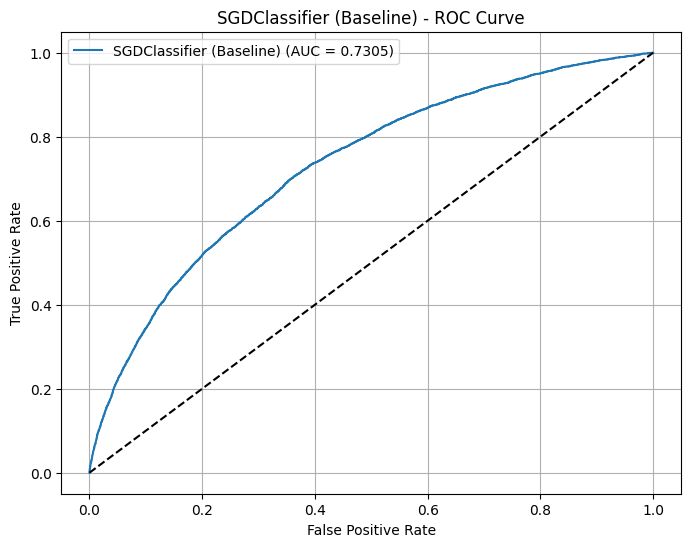


--- Optuna Optimization for SGDClassifier ---


[I 2025-04-09 10:55:01,822] Using an existing study with name 'sgd_optimization' instead of creating a new one.


EarlyStoppingCallback initialized: patience=5, min_improvement=0.002
Starting Optuna optimization for SGD with max 40 trials (early stopping enabled)...


[I 2025-04-09 10:55:10,376] Trial 222 finished with value: 0.6981427043406301 and parameters: {'alpha': 0.0011775926322523836, 'max_iter': 1328, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'constant', 'eta0': 0.0130444216322366}. Best is trial 138 with value: 0.7524510482039067.


First trial, best_score initialized to 0.6981


[I 2025-04-09 10:55:23,390] Trial 223 finished with value: 0.7489746795300194 and parameters: {'alpha': 0.00039121957934722205, 'max_iter': 1387, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.004362031048850333}. Best is trial 138 with value: 0.7524510482039067.


Trial 223: New best 0.7490 (improved by 0.0508)


[I 2025-04-09 10:55:32,118] Trial 224 finished with value: 0.7488777597419259 and parameters: {'alpha': 0.0015509277434913886, 'max_iter': 1580, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0031427781949124826}. Best is trial 138 with value: 0.7524510482039067.


Trial 224: No improvement (1/5). Score: 0.7489, Best: 0.7490
Timeout: optimization stopped after 0.50 minutes


[I 2025-04-09 10:55:45,575] Trial 225 finished with value: 0.7489685631786698 and parameters: {'alpha': 0.0010568690138763382, 'max_iter': 1693, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02225707024102417}. Best is trial 138 with value: 0.7524510482039067.


Trial 225: No improvement (2/5). Score: 0.7490, Best: 0.7490
Timeout: optimization stopped after 0.73 minutes


[I 2025-04-09 10:55:55,840] Trial 226 finished with value: 0.7476905340857225 and parameters: {'alpha': 0.0020344346599256427, 'max_iter': 1745, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'invscaling', 'eta0': 0.005883671223927586}. Best is trial 138 with value: 0.7524510482039067.


Trial 226: No improvement (3/5). Score: 0.7477, Best: 0.7490
Timeout: optimization stopped after 0.90 minutes


[I 2025-04-09 10:56:09,252] Trial 227 finished with value: 0.7489645375640939 and parameters: {'alpha': 0.0009515537280302247, 'max_iter': 1556, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.011126077738864995}. Best is trial 138 with value: 0.7524510482039067.


Trial 227: No improvement (4/5). Score: 0.7490, Best: 0.7490
Timeout: optimization stopped after 1.12 minutes


[I 2025-04-09 10:56:23,856] Trial 228 finished with value: 0.7489323426669923 and parameters: {'alpha': 0.0013423999134683363, 'max_iter': 1514, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01269259247738517}. Best is trial 138 with value: 0.7524510482039067.


Trial 228: No improvement (5/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp')]
Timeout: optimization stopped after 1.37 minutes


[I 2025-04-09 10:56:38,096] Trial 229 finished with value: 0.7489864034645045 and parameters: {'alpha': 0.0007293669902800511, 'max_iter': 1458, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01650109284062438}. Best is trial 138 with value: 0.7524510482039067.


Trial 229: No improvement (6/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp')]
Timeout: optimization stopped after 1.60 minutes


[I 2025-04-09 10:56:51,138] Trial 230 finished with value: 0.748939069094887 and parameters: {'alpha': 0.0010921236222547165, 'max_iter': 1657, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009249628439117842}. Best is trial 138 with value: 0.7524510482039067.


Trial 230: No improvement (7/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp')]
Timeout: optimization stopped after 1.82 minutes


[I 2025-04-09 10:57:04,843] Trial 231 finished with value: 0.7489999609684606 and parameters: {'alpha': 0.0008406705981698865, 'max_iter': 1505, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.013708900955619604}. Best is trial 138 with value: 0.7524510482039067.


Trial 231: No improvement (8/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp')]
Timeout: optimization stopped after 2.05 minutes


[I 2025-04-09 10:57:17,328] Trial 232 finished with value: 0.7488925429653643 and parameters: {'alpha': 0.0015826126769879002, 'max_iter': 1621, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.008333757534554445}. Best is trial 138 with value: 0.7524510482039067.


Trial 232: No improvement (9/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp')]
Timeout: optimization stopped after 2.26 minutes


[I 2025-04-09 10:57:29,825] Trial 233 finished with value: 0.7487320059982548 and parameters: {'alpha': 0.0005236364237952833, 'max_iter': 1892, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': None, 'learning_rate': 'adaptive', 'eta0': 0.015429449545633852}. Best is trial 138 with value: 0.7524510482039067.


Trial 233: No improvement (10/5). Score: 0.7487, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp')]
Timeout: optimization stopped after 2.47 minutes


[I 2025-04-09 10:57:43,910] Trial 234 finished with value: 0.7489110178198682 and parameters: {'alpha': 0.0012348536142078232, 'max_iter': 1402, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02943110045967082}. Best is trial 138 with value: 0.7524510482039067.


Trial 234: No improvement (11/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp')]
Timeout: optimization stopped after 2.70 minutes


[I 2025-04-09 10:57:59,950] Trial 235 finished with value: 0.7490029890856194 and parameters: {'alpha': 0.0009483901403691759, 'max_iter': 1563, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.018762780664110898}. Best is trial 138 with value: 0.7524510482039067.


Trial 235: No improvement (12/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp')]
Timeout: optimization stopped after 2.97 minutes


[I 2025-04-09 10:58:11,236] Trial 236 finished with value: 0.7489906294691864 and parameters: {'alpha': 0.0006696939400875617, 'max_iter': 2996, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0038498513847219106}. Best is trial 138 with value: 0.7524510482039067.


Trial 236: No improvement (13/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp')]
Timeout: optimization stopped after 3.16 minutes


[I 2025-04-09 10:58:24,390] Trial 237 finished with value: 0.7488521153747372 and parameters: {'alpha': 0.0018574478486136892, 'max_iter': 1710, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.006982373514135774}. Best is trial 138 with value: 0.7524510482039067.


Trial 237: No improvement (14/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp')]
Timeout: optimization stopped after 3.38 minutes


[I 2025-04-09 10:58:36,414] Trial 238 finished with value: 0.7489220270296417 and parameters: {'alpha': 0.0014574882597582412, 'max_iter': 2120, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.007139734513217184}. Best is trial 138 with value: 0.7524510482039067.


Trial 238: No improvement (15/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp')]
Timeout: optimization stopped after 3.58 minutes


[I 2025-04-09 10:58:47,823] Trial 239 finished with value: 0.748871596632885 and parameters: {'alpha': 0.0018225115134742234, 'max_iter': 2249, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.005586966319165451}. Best is trial 138 with value: 0.7524510482039067.


Trial 239: No improvement (16/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp')]
Timeout: optimization stopped after 3.77 minutes


[I 2025-04-09 10:59:01,258] Trial 240 finished with value: 0.7489483627426966 and parameters: {'alpha': 0.0011290844376201043, 'max_iter': 2183, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.010003894260707524}. Best is trial 138 with value: 0.7524510482039067.


Trial 240: No improvement (17/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp')]
Timeout: optimization stopped after 3.99 minutes


[I 2025-04-09 10:59:15,390] Trial 241 finished with value: 0.7489263677019955 and parameters: {'alpha': 0.0013446911071219286, 'max_iter': 2026, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.011938634346495778}. Best is trial 138 with value: 0.7524510482039067.


Trial 241: No improvement (18/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp')]
Timeout: optimization stopped after 4.23 minutes


[I 2025-04-09 10:59:31,793] Trial 242 finished with value: 0.7489918217903175 and parameters: {'alpha': 0.0008626172977909279, 'max_iter': 2078, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.039868526220883556}. Best is trial 138 with value: 0.7524510482039067.


Trial 242: No improvement (19/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp')]
Timeout: optimization stopped after 4.50 minutes


[I 2025-04-09 10:59:42,596] Trial 243 finished with value: 0.7489712105546271 and parameters: {'alpha': 0.00104382183176428, 'max_iter': 1652, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0020267557817502963}. Best is trial 138 with value: 0.7524510482039067.


Trial 243: No improvement (20/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp')]
Timeout: optimization stopped after 4.68 m

[I 2025-04-09 10:59:54,922] Trial 244 finished with value: 0.7488731084649078 and parameters: {'alpha': 0.00173279193400787, 'max_iter': 1954, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.00820522720880378}. Best is trial 138 with value: 0.7524510482039067.


Trial 244: No improvement (21/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp')]
Timeo

[I 2025-04-09 11:00:07,280] Trial 245 finished with value: 0.7489892156056601 and parameters: {'alpha': 0.0007631959312832759, 'max_iter': 1758, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.00528971032947666}. Best is trial 138 with value: 0.7524510482039067.


Trial 245: No improvement (22/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:00:20,836] Trial 246 finished with value: 0.7487731293878614 and parameters: {'alpha': 0.0022034681724359922, 'max_iter': 1590, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.022869860861019383}. Best is trial 138 with value: 0.7524510482039067.


Trial 246: No improvement (23/5). Score: 0.7488, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:00:33,129] Trial 247 finished with value: 0.7489044917820797 and parameters: {'alpha': 0.0015016072030171069, 'max_iter': 1627, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.011489715919587223}. Best is trial 138 with value: 0.7524510482039067.


Trial 247: No improvement (24/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:00:46,531] Trial 248 finished with value: 0.7489568180918955 and parameters: {'alpha': 0.001168233646955406, 'max_iter': 1673, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009631210911775216}. Best is trial 138 with value: 0.7524510482039067.


Trial 248: No improvement (25/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:01:02,170] Trial 249 finished with value: 0.7488782061665512 and parameters: {'alpha': 0.0016689310816681538, 'max_iter': 1479, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.013860290403528451}. Best is trial 138 with value: 0.7524510482039067.


Trial 249: No improvement (26/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:01:15,727] Trial 250 finished with value: 0.7489637938941447 and parameters: {'alpha': 0.000964915289484543, 'max_iter': 1710, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.011228754371805445}. Best is trial 138 with value: 0.7524510482039067.


Trial 250: No improvement (27/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:01:29,455] Trial 251 finished with value: 0.7489039017445451 and parameters: {'alpha': 0.0014580370014620559, 'max_iter': 1542, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.016662407376994023}. Best is trial 138 with value: 0.7524510482039067.


Trial 251: No improvement (28/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:01:42,162] Trial 252 finished with value: 0.7489603048797417 and parameters: {'alpha': 0.0012672132049714939, 'max_iter': 1614, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.0077353660122692364}. Best is trial 138 with value: 0.7524510482039067.


Trial 252: No improvement (29/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:01:53,399] Trial 253 finished with value: 0.7487517900681187 and parameters: {'alpha': 0.002434488262787235, 'max_iter': 1804, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.002614664296175027}. Best is trial 138 with value: 0.7524510482039067.


Trial 253: No improvement (30/5). Score: 0.7488, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:02:00,389] Trial 254 finished with value: 0.7466081625525354 and parameters: {'alpha': 0.0009026388537773326, 'max_iter': 1677, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'optimal'}. Best is trial 138 with value: 0.7524510482039067.


Trial 254: No improvement (31/5). Score: 0.7466, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:02:12,936] Trial 255 finished with value: 0.7489490529752842 and parameters: {'alpha': 0.001130186023234637, 'max_iter': 1525, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.006328247604885015}. Best is trial 138 with value: 0.7524510482039067.


Trial 255: No improvement (32/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:02:29,940] Trial 256 finished with value: 0.7490234433490601 and parameters: {'alpha': 0.0006406656463485986, 'max_iter': 1608, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.09771044522957403}. Best is trial 138 with value: 0.7524510482039067.


Trial 256: No improvement (33/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:02:38,551] Trial 257 finished with value: 0.7488808691284057 and parameters: {'alpha': 0.0017815248695005857, 'max_iter': 1759, 'loss': 'log_loss', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.01233419274740706}. Best is trial 138 with value: 0.7524510482039067.


Trial 257: No improvement (34/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:02:53,158] Trial 258 finished with value: 0.7490025070360862 and parameters: {'alpha': 0.0007983174245613516, 'max_iter': 1435, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.009475185401185816}. Best is trial 138 with value: 0.7524510482039067.


Trial 258: No improvement (35/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:02:59,337] Trial 259 finished with value: 0.6752206612352487 and parameters: {'alpha': 0.0013519250774668774, 'max_iter': 1970, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'constant', 'eta0': 0.0521051203318572}. Best is trial 138 with value: 0.7524510482039067.


Trial 259: No improvement (36/5). Score: 0.6752, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:03:12,992] Trial 260 finished with value: 0.7489656797876988 and parameters: {'alpha': 0.0009818364787946723, 'max_iter': 2097, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.014867428192720888}. Best is trial 138 with value: 0.7524510482039067.


Trial 260: No improvement (37/5). Score: 0.7490, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

[I 2025-04-09 11:03:26,945] Trial 261 finished with value: 0.7489078850545431 and parameters: {'alpha': 0.0012106510415130383, 'max_iter': 1653, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.02609064363647672}. Best is trial 138 with value: 0.7524510482039067.


Trial 261: No improvement (38/5). Score: 0.7489, Best: 0.7490
EARLY STOPPING TRIGGERED after 5 trials without 0.0020 improvement
Trial history: [(222, 0.6981427043406301, 'first'), (223, 0.7489746795300194, 'improved'), (224, 0.7488777597419259, 'no_imp'), (225, 0.7489685631786698, 'no_imp'), (226, 0.7476905340857225, 'no_imp'), (227, 0.7489645375640939, 'no_imp'), (228, 0.7489323426669923, 'no_imp'), (229, 0.7489864034645045, 'no_imp'), (230, 0.748939069094887, 'no_imp'), (231, 0.7489999609684606, 'no_imp'), (232, 0.7488925429653643, 'no_imp'), (233, 0.7487320059982548, 'no_imp'), (234, 0.7489110178198682, 'no_imp'), (235, 0.7490029890856194, 'no_imp'), (236, 0.7489906294691864, 'no_imp'), (237, 0.7488521153747372, 'no_imp'), (238, 0.7489220270296417, 'no_imp'), (239, 0.748871596632885, 'no_imp'), (240, 0.7489483627426966, 'no_imp'), (241, 0.7489263677019955, 'no_imp'), (242, 0.7489918217903175, 'no_imp'), (243, 0.7489712105546271, 'no_imp'), (244, 0.7488731084649078, 'no_imp'), (245,

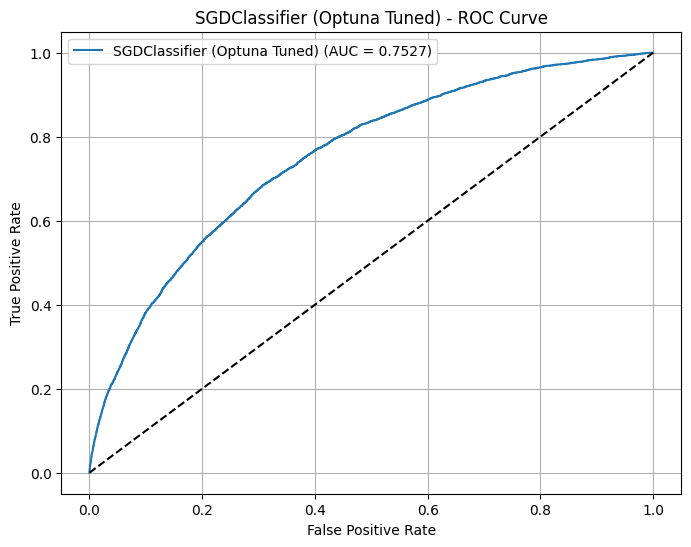


--- Top 50 Feature Importances ---
Sum of importances: 5.0649


,feature,importance
0,WEIGHTED_EXT_SOURCE,0.35930
5,EXT_SOURCE_1,0.24308
16,DAYS_BIRTH,0.20637
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.20352
3,EXT_SOURCE_3,0.20285
70,AGE_EMPLOYED_DIFF_MIN_AGG_NAME_EDUCATION_TYPE_...,0.17668
25,AGE_EMPLOYED_DIFF_MEAN_AGG_NAME_EDUCATION_TYPE...,0.17004
45,AGE_EMPLOYED_DIFF_MEAN_AGG_OCCUPATION_TYPE_ORG...,0.16645
42,AMT_INCOME_TOTAL_MEAN_AGG_NAME_EDUCATION_TYPE_...,0.16323
4,EXT_SOURCE_2,0.15021


In [9]:
# --- Model 2: SGDClassifier with Optuna Optimization ---
print("\n" + "="*60)
print("Model 2: SGDClassifier with Optuna Optimization")
print("="*60)

# Step 2.1: Baseline Pipeline (No change needed here)
print("\n--- Baseline SGDClassifier Training ---")
sgd_base_pipeline = ImblearnPipeline([
    # ('smote', SMOTE_VARIANT), # Keep SMOTE here
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(loss='log_loss', penalty='l2', random_state=SEED,
                            class_weight='balanced', n_jobs=8, tol=1e-5))
])

sgd_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = sgd_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "SGDClassifier (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "SGDClassifier (Baseline)")

# Step 2.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for SGDClassifier ---")

# Define the objective function for Optuna
def objective_sgd(trial):
    # Define hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 3000)
    loss = trial.suggest_categorical('loss', ['log_loss', 'modified_huber'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])
    l1_ratio = 0.15 # Default if penalty is elasticnet, fixed here for simplicity, could also tune
    class_weight_opt = trial.suggest_categorical('class_weight', ['balanced', None])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'constant', 'invscaling', 'adaptive'])
    eta0 = 0.01 
    if learning_rate != 'optimal':
        eta0 = trial.suggest_float('eta0', 1e-4, 0.5, log=True)

    # Create the pipeline with suggested parameters
    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', SGDClassifier(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else 0.15, # Apply l1_ratio only if relevant
            max_iter=max_iter,
            class_weight=class_weight_opt,
            learning_rate=learning_rate,
            eta0=eta0,
            random_state=SEED,
            n_jobs=5,
            tol=1e-5 # Use tolerance for convergence
        ))
    ])

    # Evaluate using cross-validation
    try:
        # Using roc_auc as the optimization target
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        # Handle potential errors during CV
        if np.isnan(auc_score):
            return 0.0 # Return low score if CV fails
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0 # Return low score for failed trials

# Create an Optuna study
study_sgd = optuna.create_study(direction='maximize',
                                study_name='sgd_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db', # Save study progress
                                load_if_exists=True) # Resume if exists

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=5, min_improvement=0.002)  
timeout = TimeoutCallback(timeout=30)

# Run optimization with callbacks
print(f"Starting Optuna optimization for SGD with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_sgd.optimize(objective_sgd, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build the final pipeline
best_params_sgd_raw = study_sgd.best_params
# Need to prefix with 'model__' for pipeline
best_params_sgd = {f'model__{k}': v for k, v in best_params_sgd_raw.items()}
print(f"\nBest Params (SGDClassifier): {best_params_sgd_raw}")
print(f"Best CV ROC AUC score: {study_sgd.best_value:.4f}")

best_sgd_pipeline = ImblearnPipeline([
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(random_state=SEED, n_jobs=8, tol=1e-5, class_weight='balanced'))
])
best_sgd_pipeline.set_params(**best_params_sgd)

# Fit the best pipeline on the full training data
print("\nFitting best SGD pipeline on full training data...")
best_sgd_pipeline.fit(X_train, y_train)

# Step 2.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned SGD model...")
y_prob_oof_sgd = cross_val_predict(best_sgd_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_sgd = find_optimal_threshold_j_statistic(y_train, y_prob_oof_sgd)

y_pred_proba_test_tuned = best_sgd_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_sgd).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "SGDClassifier (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "SGDClassifier (Optuna Tuned)")

# Feature importance via coefficients
final_sgd_model = best_sgd_pipeline.named_steps['model']
if hasattr(final_sgd_model, 'coef_'):
     get_feature_importance(final_sgd_model, feature_names)

model_objects['SGD'] = best_sgd_pipeline # Store the best pipeline

# 5. Model 3: XGBoost


Model 3: XGBoost with Optuna Optimization & GPU

--- Baseline XGBoost Training ---

--- Evaluation Metrics for XGBoost (Baseline) ---
AUC ROC:        0.7603
Gini Coefficient: 0.5206
KS Statistic:   0.3954
Accuracy:       0.7497
Precision:      0.1858
Recall (TPR):   0.6207
F1-Score:       0.2859
Brier Score:    0.1667
Log Loss:       0.5001

Confusion Matrix:
[[43027 13510]
 [ 1883  3082]]


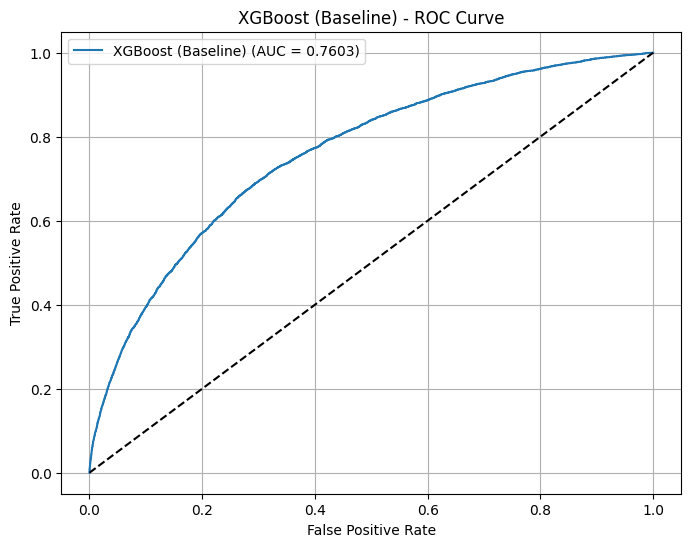


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
0,WEIGHTED_EXT_SOURCE,0.11121
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.02006
15,B_B_CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,0.01694
20,CREDIT_GOODS_RATIO,0.01663
101,FLAG_DOCUMENT_3,0.01457
6,CREDIT_ANNUITY_RATIO,0.01457
42,AMT_INCOME_TOTAL_MEAN_AGG_NAME_EDUCATION_TYPE_...,0.01389
25,AGE_EMPLOYED_DIFF_MEAN_AGG_NAME_EDUCATION_TYPE...,0.01373
87,CREDIT_GOODS_DIFF,0.01208
64,AMT_INCOME_TOTAL_MEAN_AGG_FLAG_OWN_CAR_FLAG_OW...,0.01201


[I 2025-04-09 11:03:59,779] Using an existing study with name 'xgb_optimization' instead of creating a new one.



--- Optuna Optimization for XGBoost ---
EarlyStoppingCallback initialized: patience=5, min_improvement=0.001
Starting Optuna optimization for XGBoost with max 40 trials (early stopping enabled)...


[I 2025-04-09 11:04:59,323] Trial 157 finished with value: 0.7663459628975046 and parameters: {'n_estimators': 887, 'max_depth': 7, 'learning_rate': 0.012324780222989277, 'subsample': 0.9882564536617595, 'colsample_bytree': 0.6029839896348109, 'gamma': 0.34493341743664774, 'reg_alpha': 0.18137684767865953, 'reg_lambda': 1.584086764719359e-08}. Best is trial 135 with value: 0.7746124371852164.


First trial, best_score initialized to 0.7663


[I 2025-04-09 11:06:08,538] Trial 158 finished with value: 0.7635855852895137 and parameters: {'n_estimators': 757, 'max_depth': 8, 'learning_rate': 0.013213071505017394, 'subsample': 0.9413922154440972, 'colsample_bytree': 0.6539921527126831, 'gamma': 0.3116902267177235, 'reg_alpha': 0.2813357599151315, 'reg_lambda': 3.533994737169687e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 158: No improvement (1/5). Score: 0.7636, Best: 0.7663
Timeout: optimization stopped after 2.15 minutes


[I 2025-04-09 11:07:37,013] Trial 159 finished with value: 0.7590683514398041 and parameters: {'n_estimators': 958, 'max_depth': 8, 'learning_rate': 0.017119620702672936, 'subsample': 0.963458736761557, 'colsample_bytree': 0.8843759764979985, 'gamma': 0.32733671028781836, 'reg_alpha': 0.11158339772065806, 'reg_lambda': 1.1147609206366299e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 159: No improvement (2/5). Score: 0.7591, Best: 0.7663
Timeout: optimization stopped after 3.62 minutes


[I 2025-04-09 11:08:22,060] Trial 160 finished with value: 0.7674510146942279 and parameters: {'n_estimators': 840, 'max_depth': 6, 'learning_rate': 0.01449102101609168, 'subsample': 0.9995169789500222, 'colsample_bytree': 0.6425321371890125, 'gamma': 0.2966237719076303, 'reg_alpha': 0.6819683153671305, 'reg_lambda': 7.823088306680941e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 160: New best 0.7675 (improved by 0.0011)
Timeout: optimization stopped after 4.37 minutes


[I 2025-04-09 11:10:10,696] Trial 161 finished with value: 0.7587364709124743 and parameters: {'n_estimators': 934, 'max_depth': 9, 'learning_rate': 0.011833875136790791, 'subsample': 0.9760627125385024, 'colsample_bytree': 0.6248613157100927, 'gamma': 0.35418016115825773, 'reg_alpha': 0.46034883512264896, 'reg_lambda': 2.1292384126679938e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 161: No improvement (1/5). Score: 0.7587, Best: 0.7675
Timeout: optimization stopped after 6.18 minutes


[I 2025-04-09 11:11:27,557] Trial 162 finished with value: 0.7631577479598783 and parameters: {'n_estimators': 872, 'max_depth': 8, 'learning_rate': 0.013410800766404598, 'subsample': 0.9543906524896314, 'colsample_bytree': 0.636187298192431, 'gamma': 0.3015813951909521, 'reg_alpha': 0.12918280493300963, 'reg_lambda': 3.778809525165956e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 162: No improvement (2/5). Score: 0.7632, Best: 0.7675
Timeout: optimization stopped after 7.46 minutes


[I 2025-04-09 11:11:47,312] Trial 163 finished with value: 0.7566394218504972 and parameters: {'n_estimators': 136, 'max_depth': 8, 'learning_rate': 0.01586221425513233, 'subsample': 0.9631146503807374, 'colsample_bytree': 0.6213499216198721, 'gamma': 0.30719984573203557, 'reg_alpha': 0.17665919431938956, 'reg_lambda': 2.8888506623309744e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 163: No improvement (3/5). Score: 0.7566, Best: 0.7675
Timeout: optimization stopped after 7.79 minutes


[I 2025-04-09 11:13:03,086] Trial 164 finished with value: 0.7628413247460383 and parameters: {'n_estimators': 863, 'max_depth': 8, 'learning_rate': 0.013688220455853708, 'subsample': 0.9643012547959697, 'colsample_bytree': 0.6178413034950538, 'gamma': 0.33546951235948647, 'reg_alpha': 0.995948650106501, 'reg_lambda': 5.153727755257866e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 164: No improvement (4/5). Score: 0.7628, Best: 0.7675
Timeout: optimization stopped after 9.06 minutes


[I 2025-04-09 11:14:20,214] Trial 165 finished with value: 0.7617028228308544 and parameters: {'n_estimators': 905, 'max_depth': 8, 'learning_rate': 0.014740184861682286, 'subsample': 0.9734237215052373, 'colsample_bytree': 0.6271442153681501, 'gamma': 0.28642344185115404, 'reg_alpha': 0.2094132535361737, 'reg_lambda': 1.6304340860896594e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 165: No improvement (5/5). Score: 0.7617, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp')]
Timeout: optimization stopped after 10.34 minutes


[I 2025-04-09 11:15:23,926] Trial 166 finished with value: 0.7664645971801505 and parameters: {'n_estimators': 896, 'max_depth': 7, 'learning_rate': 0.010796513939365952, 'subsample': 0.9307892836473778, 'colsample_bytree': 0.7995174091503784, 'gamma': 0.3208757057928176, 'reg_alpha': 0.3517461127744135, 'reg_lambda': 2.8830286218901404e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 166: No improvement (6/5). Score: 0.7665, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp')]
Timeout: optimization stopped after 11.40 minutes


[I 2025-04-09 11:16:38,999] Trial 167 finished with value: 0.7584245575892999 and parameters: {'n_estimators': 826, 'max_depth': 8, 'learning_rate': 0.020291025160944578, 'subsample': 0.9810260506033063, 'colsample_bytree': 0.8718795118078625, 'gamma': 0.30436190417191034, 'reg_alpha': 0.5833497342447312, 'reg_lambda': 1.0046180761487123e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 167: No improvement (7/5). Score: 0.7584, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp')]
Timeout: optimization stopped after 12.65 minutes


[I 2025-04-09 11:17:25,083] Trial 168 finished with value: 0.7671978184553365 and parameters: {'n_estimators': 850, 'max_depth': 6, 'learning_rate': 0.01291814217246495, 'subsample': 0.9874929659228215, 'colsample_bytree': 0.6086188893904534, 'gamma': 0.27860925650578766, 'reg_alpha': 0.07723326471561828, 'reg_lambda': 1.0253506313857963e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 168: No improvement (8/5). Score: 0.7672, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp')]
Timeout: optimization stopped after 13.42 minutes


[I 2025-04-09 11:18:26,153] Trial 169 finished with value: 0.7647334303933945 and parameters: {'n_estimators': 958, 'max_depth': 7, 'learning_rate': 0.01800904274816566, 'subsample': 0.9467911520603024, 'colsample_bytree': 0.616652894968064, 'gamma': 0.3140130494682747, 'reg_alpha': 0.2716559513221291, 'reg_lambda': 4.930382637281618e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 169: No improvement (9/5). Score: 0.7647, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp')]
Timeout: optimization stopped after 14.44 minutes


[I 2025-04-09 11:19:09,712] Trial 170 finished with value: 0.7639587600946793 and parameters: {'n_estimators': 431, 'max_depth': 8, 'learning_rate': 0.016131418900299874, 'subsample': 0.9567844850642919, 'colsample_bytree': 0.6345754492519254, 'gamma': 0.3395952971603671, 'reg_alpha': 0.030167867546576917, 'reg_lambda': 2.7184369245212497e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 170: No improvement (10/5). Score: 0.7640, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp')]
Timeout: optimization stopped after 15.17 minutes


[I 2025-04-09 11:19:58,635] Trial 171 finished with value: 0.7674868984391993 and parameters: {'n_estimators': 923, 'max_depth': 6, 'learning_rate': 0.014246222131623772, 'subsample': 0.9683658385563869, 'colsample_bytree': 0.649389638265908, 'gamma': 0.29370500905546887, 'reg_alpha': 0.16874082759753503, 'reg_lambda': 0.005792027330489577}. Best is trial 135 with value: 0.7746124371852164.


Trial 171: No improvement (11/5). Score: 0.7675, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp')]
Timeout: optimization stopped after 15.98 minutes


[I 2025-04-09 11:21:16,326] Trial 172 finished with value: 0.7609059899430439 and parameters: {'n_estimators': 935, 'max_depth': 8, 'learning_rate': 0.01550119580521237, 'subsample': 0.9761186637965596, 'colsample_bytree': 0.6065634795717355, 'gamma': 0.4965107451069212, 'reg_alpha': 0.408063523898309, 'reg_lambda': 5.085912620525117e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 172: No improvement (12/5). Score: 0.7609, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp')]
Timeout: optimization stopped after 17.28 minutes


[I 2025-04-09 11:22:33,580] Trial 173 finished with value: 0.7614757724910562 and parameters: {'n_estimators': 918, 'max_depth': 8, 'learning_rate': 0.015282626593970585, 'subsample': 0.9743061250687481, 'colsample_bytree': 0.60048196991698, 'gamma': 0.2958150728985446, 'reg_alpha': 0.4759838600929722, 'reg_lambda': 0.0482425252703859}. Best is trial 135 with value: 0.7746124371852164.


Trial 173: No improvement (13/5). Score: 0.7615, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp')]
Timeout: optimization stopped after 18.56 minutes


[I 2025-04-09 11:23:50,681] Trial 174 finished with value: 0.7633268961351584 and parameters: {'n_estimators': 884, 'max_depth': 8, 'learning_rate': 0.013500916930610807, 'subsample': 0.9597184610602694, 'colsample_bytree': 0.616221398558719, 'gamma': 0.306797296641638, 'reg_alpha': 0.6469231118934329, 'reg_lambda': 6.109049363789273e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 174: No improvement (14/5). Score: 0.7633, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp')]
Timeout: optimization stopped after 19.85 minutes


[I 2025-04-09 11:25:03,906] Trial 175 finished with value: 0.7269096787463826 and parameters: {'n_estimators': 945, 'max_depth': 8, 'learning_rate': 0.0880596658241539, 'subsample': 0.9902833468477394, 'colsample_bytree': 0.6268707044463998, 'gamma': 0.322174432785652, 'reg_alpha': 0.3591246336683926, 'reg_lambda': 1.7595233094945536e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 175: No improvement (15/5). Score: 0.7269, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp')]
Timeout: optimization stopped after 21.07 minutes


[I 2025-04-09 11:26:29,303] Trial 176 finished with value: 0.7592130035945308 and parameters: {'n_estimators': 975, 'max_depth': 8, 'learning_rate': 0.01738257862780313, 'subsample': 0.9512162345364931, 'colsample_bytree': 0.7680985889948161, 'gamma': 0.32918119987273886, 'reg_alpha': 0.26456307112165317, 'reg_lambda': 7.900286155962818e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 176: No improvement (16/5). Score: 0.7592, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp')]
Timeout: optimization stopped after 22.49 minutes


[I 2025-04-09 11:27:33,517] Trial 177 finished with value: 0.7661598121783613 and parameters: {'n_estimators': 901, 'max_depth': 7, 'learning_rate': 0.012420759969933857, 'subsample': 0.9663912761310332, 'colsample_bytree': 0.8815965464474983, 'gamma': 0.2727997880780656, 'reg_alpha': 0.7367164517847173, 'reg_lambda': 1.4659376728473158e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 177: No improvement (17/5). Score: 0.7662, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp')]
Timeout: optimization stopped after 23.56 minutes


[I 2025-04-09 11:28:48,649] Trial 178 finished with value: 0.7620407484597181 and parameters: {'n_estimators': 875, 'max_depth': 8, 'learning_rate': 0.01431830052430722, 'subsample': 0.9802485550432365, 'colsample_bytree': 0.6319130698265422, 'gamma': 0.2843337935892167, 'reg_alpha': 0.15932066360760563, 'reg_lambda': 3.4873220714746506e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 178: No improvement (18/5). Score: 0.7620, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp')]
Timeout: optimization stopped after 24.8

[I 2025-04-09 11:29:19,638] Trial 179 finished with value: 0.7620745320050497 and parameters: {'n_estimators': 932, 'max_depth': 3, 'learning_rate': 0.01179662137316252, 'subsample': 0.9444507190066306, 'colsample_bytree': 0.6011897971746306, 'gamma': 0.3124207031620511, 'reg_alpha': 0.9947087462794131, 'reg_lambda': 2.212405175168087e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 179: No improvement (19/5). Score: 0.7621, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp')]
Tim

[I 2025-04-09 11:30:11,369] Trial 180 finished with value: 0.7673095531953015 and parameters: {'n_estimators': 959, 'max_depth': 6, 'learning_rate': 0.016729046461626228, 'subsample': 0.9573327383375861, 'colsample_bytree': 0.8879817932652314, 'gamma': 0.2988275557857457, 'reg_alpha': 0.47689608367657355, 'reg_lambda': 3.858994827076552e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 180: No improvement (20/5). Score: 0.7673, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:31:10,005] Trial 181 finished with value: 0.7638861637689924 and parameters: {'n_estimators': 860, 'max_depth': 7, 'learning_rate': 0.0186957086856599, 'subsample': 0.972494631126693, 'colsample_bytree': 0.8689225438015286, 'gamma': 0.33549934661018255, 'reg_alpha': 0.22990915246283258, 'reg_lambda': 1.4311321718591888e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 181: No improvement (21/5). Score: 0.7639, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:32:38,882] Trial 182 finished with value: 0.7598632015788425 and parameters: {'n_estimators': 982, 'max_depth': 8, 'learning_rate': 0.015447376467733687, 'subsample': 0.9377872291185381, 'colsample_bytree': 0.8610360666973953, 'gamma': 0.30618452258298134, 'reg_alpha': 0.3896259857261105, 'reg_lambda': 3.0000238179088805e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 182: No improvement (22/5). Score: 0.7599, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:33:32,688] Trial 183 finished with value: 0.7672292457470039 and parameters: {'n_estimators': 982, 'max_depth': 6, 'learning_rate': 0.013104940429343204, 'subsample': 0.9661591859254234, 'colsample_bytree': 0.9001383925526514, 'gamma': 0.3177538641294458, 'reg_alpha': 0.6047553920219397, 'reg_lambda': 6.368495475046735e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 183: No improvement (23/5). Score: 0.7672, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:35:00,853] Trial 184 finished with value: 0.7602791730310008 and parameters: {'n_estimators': 965, 'max_depth': 8, 'learning_rate': 0.014298270909171507, 'subsample': 0.9812505432799933, 'colsample_bytree': 0.9061444892018058, 'gamma': 0.45398687823973094, 'reg_alpha': 0.13586780205122476, 'reg_lambda': 2.4156389770136424e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 184: No improvement (24/5). Score: 0.7603, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:36:26,872] Trial 185 finished with value: 0.7598936452890726 and parameters: {'n_estimators': 941, 'max_depth': 8, 'learning_rate': 0.01630048363216377, 'subsample': 0.9488644308704693, 'colsample_bytree': 0.8920888172475356, 'gamma': 0.29103695399191304, 'reg_alpha': 0.29494998710435594, 'reg_lambda': 4.151146890958304e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 185: No improvement (25/5). Score: 0.7599, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:37:29,476] Trial 186 finished with value: 0.7645613080949565 and parameters: {'n_estimators': 914, 'max_depth': 7, 'learning_rate': 0.01533068467244187, 'subsample': 0.9922447370993085, 'colsample_bytree': 0.8772536908531356, 'gamma': 0.32477813178312637, 'reg_alpha': 0.48797788826961136, 'reg_lambda': 9.691934677477661e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 186: No improvement (26/5). Score: 0.7646, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:38:20,983] Trial 187 finished with value: 0.7678739842142026 and parameters: {'n_estimators': 986, 'max_depth': 6, 'learning_rate': 0.01347455367902731, 'subsample': 0.957726912738526, 'colsample_bytree': 0.6439567334885058, 'gamma': 0.30477656734202485, 'reg_alpha': 0.09018846983331957, 'reg_lambda': 1.8186963483042774e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 187: No improvement (27/5). Score: 0.7679, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:39:43,947] Trial 188 finished with value: 0.7634913178871303 and parameters: {'n_estimators': 959, 'max_depth': 8, 'learning_rate': 0.01131207949283667, 'subsample': 0.9729980806837454, 'colsample_bytree': 0.6140018203929745, 'gamma': 0.34481128913416265, 'reg_alpha': 0.7107394590032612, 'reg_lambda': 1.0088487638107695e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 188: No improvement (28/5). Score: 0.7635, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:40:43,324] Trial 189 finished with value: 0.7663420831223949 and parameters: {'n_estimators': 896, 'max_depth': 7, 'learning_rate': 0.012239776027008613, 'subsample': 0.9849677438181017, 'colsample_bytree': 0.6201644536255754, 'gamma': 0.29693332380758447, 'reg_alpha': 0.22106287004262767, 'reg_lambda': 5.39467131868336e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 189: No improvement (29/5). Score: 0.7663, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:42:34,363] Trial 190 finished with value: 0.7538396096961826 and parameters: {'n_estimators': 924, 'max_depth': 9, 'learning_rate': 0.014793715583545577, 'subsample': 0.9995960972762004, 'colsample_bytree': 0.8554619817215547, 'gamma': 0.358732634015948, 'reg_alpha': 0.3520804698716752, 'reg_lambda': 3.191692706848083e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 190: No improvement (30/5). Score: 0.7538, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:43:50,302] Trial 191 finished with value: 0.7588683543209684 and parameters: {'n_estimators': 848, 'max_depth': 8, 'learning_rate': 0.02000223414416904, 'subsample': 0.9303357925910035, 'colsample_bytree': 0.8196381223628371, 'gamma': 0.3118206321623259, 'reg_alpha': 0.7377696227990298, 'reg_lambda': 7.435084188249016e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 191: No improvement (31/5). Score: 0.7589, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:44:34,649] Trial 192 finished with value: 0.7669258011323691 and parameters: {'n_estimators': 791, 'max_depth': 6, 'learning_rate': 0.010503269401338104, 'subsample': 0.9478062532395299, 'colsample_bytree': 0.6112080914626684, 'gamma': 0.3254781882101513, 'reg_alpha': 0.9067035801006312, 'reg_lambda': 1.2800926973217114e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 192: No improvement (32/5). Score: 0.7669, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:45:31,006] Trial 193 finished with value: 0.7664977227779671 and parameters: {'n_estimators': 828, 'max_depth': 7, 'learning_rate': 0.011899187771508033, 'subsample': 0.9648508767528579, 'colsample_bytree': 0.6052928776872412, 'gamma': 0.3311563181875088, 'reg_alpha': 0.9815854716142898, 'reg_lambda': 4.082335876985563e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 193: No improvement (33/5). Score: 0.7665, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:46:26,405] Trial 194 finished with value: 0.7669399008028897 and parameters: {'n_estimators': 814, 'max_depth': 7, 'learning_rate': 0.012674977668683128, 'subsample': 0.9512620384631896, 'colsample_bytree': 0.6249829448186475, 'gamma': 0.3177891101211112, 'reg_alpha': 0.5191043769018545, 'reg_lambda': 8.443611800671884e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 194: No improvement (34/5). Score: 0.7669, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:47:33,718] Trial 195 finished with value: 0.765378292434492 and parameters: {'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.013782628989924108, 'subsample': 0.9419847371595866, 'colsample_bytree': 0.7819982311036457, 'gamma': 0.2829750614095276, 'reg_alpha': 0.3658193900356104, 'reg_lambda': 2.074530132189235e-07}. Best is trial 135 with value: 0.7746124371852164.


Trial 195: No improvement (35/5). Score: 0.7654, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

[I 2025-04-09 11:47:59,615] Trial 196 finished with value: 0.7598516095678438 and parameters: {'n_estimators': 284, 'max_depth': 7, 'learning_rate': 0.011311824742564036, 'subsample': 0.961853674540194, 'colsample_bytree': 0.6381181110228331, 'gamma': 0.30188707683902805, 'reg_alpha': 0.1820078590841246, 'reg_lambda': 2.1082185754348732e-08}. Best is trial 135 with value: 0.7746124371852164.


Trial 196: No improvement (36/5). Score: 0.7599, Best: 0.7675
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(157, 0.7663459628975046, 'first'), (158, 0.7635855852895137, 'no_imp'), (159, 0.7590683514398041, 'no_imp'), (160, 0.7674510146942279, 'improved'), (161, 0.7587364709124743, 'no_imp'), (162, 0.7631577479598783, 'no_imp'), (163, 0.7566394218504972, 'no_imp'), (164, 0.7628413247460383, 'no_imp'), (165, 0.7617028228308544, 'no_imp'), (166, 0.7664645971801505, 'no_imp'), (167, 0.7584245575892999, 'no_imp'), (168, 0.7671978184553365, 'no_imp'), (169, 0.7647334303933945, 'no_imp'), (170, 0.7639587600946793, 'no_imp'), (171, 0.7674868984391993, 'no_imp'), (172, 0.7609059899430439, 'no_imp'), (173, 0.7614757724910562, 'no_imp'), (174, 0.7633268961351584, 'no_imp'), (175, 0.7269096787463826, 'no_imp'), (176, 0.7592130035945308, 'no_imp'), (177, 0.7661598121783613, 'no_imp'), (178, 0.7620407484597181, 'no_imp'), (179, 0.7620745320050497, 'no_imp'), (18

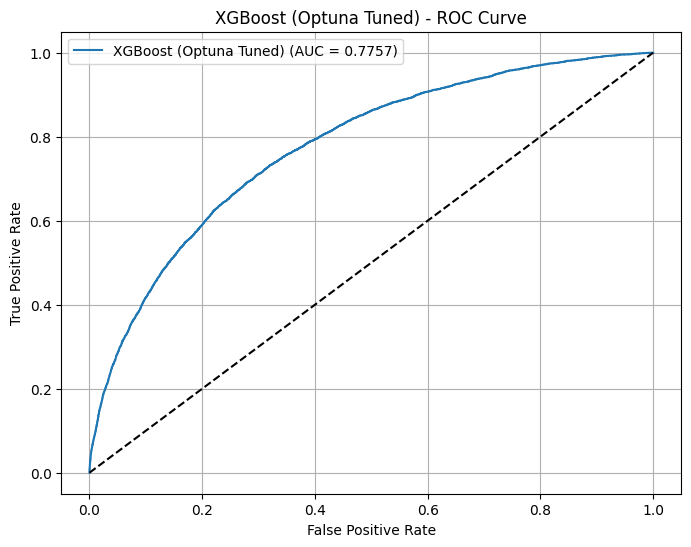


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
0,WEIGHTED_EXT_SOURCE,0.11246
1,EXT_SOURCE_MIN,0.03936
2,EXT_SOURCE_MAX,0.02602
20,CREDIT_GOODS_RATIO,0.01404
35,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.01393
101,FLAG_DOCUMENT_3,0.01369
6,CREDIT_ANNUITY_RATIO,0.01350
9,B_B_CURRENT_CREDIT_DEBT_DIFF_MIN_OVERALL,0.01163
15,B_B_CURRENT_CREDIT_DEBT_DIFF_MEAN_OVERALL,0.01142
3,EXT_SOURCE_3,0.01100


In [10]:
# --- Model 3: XGBoost with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 3: XGBoost with Optuna Optimization & GPU")
print("="*60)

# Step 3.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline XGBoost Training ---")
xgb_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=11.5,
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU if available
                               ))
])
xgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = xgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "XGBoost (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "XGBoost (Baseline)")
get_feature_importance(xgb_base_pipeline.named_steps['model'], feature_names)

# Step 3.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for XGBoost ---")

def objective_xgb(trial):
    # Define hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': SEED,
        'n_jobs': 6,
        'scale_pos_weight' : 11.5,
        'tree_method': 'gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU
    }

    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(**param))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_xgb = optuna.create_study(direction='maximize',
                                study_name='xgb_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=5, min_improvement=0.001)
timeout = TimeoutCallback(timeout=60)  # 1 min timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for XGBoost with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_xgb.optimize(objective_xgb, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_xgb_raw = study_xgb.best_params
best_params_xgb = {f'model__{k}': v for k, v in best_params_xgb_raw.items()}
print(f"\nBest Params (XGBoost): {best_params_xgb_raw}")
print(f"Best CV ROC AUC score: {study_xgb.best_value:.4f}")

best_xgb_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                use_label_encoder=False, random_state=SEED, n_jobs=6,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist'))
])
# Update only the tuned parameters
best_xgb_pipeline.set_params(**best_params_xgb)

print("\nFitting best XGBoost pipeline on full training data...")
best_xgb_pipeline.fit(X_train, y_train)

# Step 3.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned XGBoost model...")
y_prob_oof_xgb = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_xgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_xgb)

y_pred_proba_test_tuned = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_xgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "XGBoost (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "XGBoost (Optuna Tuned)")
get_feature_importance(best_xgb_pipeline.named_steps['model'], feature_names)
model_objects['XGB'] = best_xgb_pipeline # Store the best pipeline  

# 6. Model 4: LightGBM


Model 4: LightGBM with Optuna Optimization & GPU

--- Baseline LightGBM Training ---
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 18944
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 112
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 770, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 108 dense feature groups (25.34 MB) transferred to GPU in 0.012738 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469

--- Evaluation Metrics for LightGBM (Baseline) ---
AUC ROC:        0.7739
Gini Coefficient: 0.5479
KS Statistic:   0.4079
Accuracy:       0.7093
Precision:      0.1742
Rec

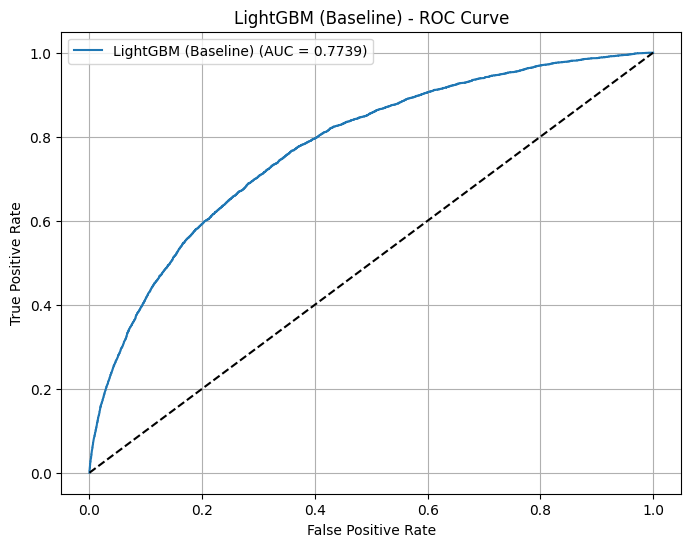


--- Top 50 Feature Importances ---
Sum of importances: 3000.0000


,feature,importance
6,CREDIT_ANNUITY_RATIO,295
0,WEIGHTED_EXT_SOURCE,109
16,DAYS_BIRTH,89
106,AMT_ANNUITY,85
20,CREDIT_GOODS_RATIO,65
10,DAYS_EMPLOYED,65
5,EXT_SOURCE_1,64
11,B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MAX_OVERALL,63
4,EXT_SOURCE_2,58
1,EXT_SOURCE_MIN,57


[I 2025-04-09 11:49:14,625] Using an existing study with name 'lgbm_optimization' instead of creating a new one.



--- Optuna Optimization for LightGBM ---
EarlyStoppingCallback initialized: patience=5, min_improvement=0.001
Starting Optuna optimization for LightGBM with max 40 trials (early stopping enabled)...


[I 2025-04-09 11:51:16,491] Trial 64 finished with value: 0.7703859203952085 and parameters: {'n_estimators': 699, 'learning_rate': 0.016088624922168504, 'num_leaves': 40, 'max_depth': 9, 'subsample': 0.9227579537005057, 'colsample_bytree': 0.6789087828343252, 'reg_alpha': 1.1559985089079616e-05, 'reg_lambda': 0.07352874777866501}. Best is trial 39 with value: 0.7736317691972663.


First trial, best_score initialized to 0.7704
Timeout: optimization stopped after 2.03 minutes


[I 2025-04-09 11:53:53,018] Trial 65 finished with value: 0.7688770296539728 and parameters: {'n_estimators': 920, 'learning_rate': 0.023105304526681403, 'num_leaves': 43, 'max_depth': 11, 'subsample': 0.9781651000681235, 'colsample_bytree': 0.6918983476774453, 'reg_alpha': 2.979677332065154e-07, 'reg_lambda': 0.4701503166858939}. Best is trial 39 with value: 0.7736317691972663.


Trial 65: No improvement (1/5). Score: 0.7689, Best: 0.7704
Timeout: optimization stopped after 4.64 minutes


[I 2025-04-09 11:56:08,262] Trial 66 finished with value: 0.7690684088849677 and parameters: {'n_estimators': 824, 'learning_rate': 0.028015689367904932, 'num_leaves': 35, 'max_depth': 10, 'subsample': 0.9423426127985531, 'colsample_bytree': 0.641506289449096, 'reg_alpha': 0.10797976323917512, 'reg_lambda': 0.03561633826725236}. Best is trial 39 with value: 0.7736317691972663.


Trial 66: No improvement (2/5). Score: 0.7691, Best: 0.7704
Timeout: optimization stopped after 6.89 minutes


[I 2025-04-09 11:57:57,746] Trial 67 finished with value: 0.7676164055550186 and parameters: {'n_estimators': 641, 'learning_rate': 0.034399675204619666, 'num_leaves': 55, 'max_depth': 6, 'subsample': 0.8839840035747951, 'colsample_bytree': 0.6999536239591815, 'reg_alpha': 6.982327501909822e-06, 'reg_lambda': 0.15280625123255231}. Best is trial 39 with value: 0.7736317691972663.


Trial 67: No improvement (3/5). Score: 0.7676, Best: 0.7704
Timeout: optimization stopped after 8.72 minutes


[I 2025-04-09 12:00:24,715] Trial 68 finished with value: 0.7700359735865356 and parameters: {'n_estimators': 751, 'learning_rate': 0.012624971710527033, 'num_leaves': 29, 'max_depth': 9, 'subsample': 0.7825636139874793, 'colsample_bytree': 0.6125867629723023, 'reg_alpha': 9.713536797807537e-08, 'reg_lambda': 0.0041456079722799735}. Best is trial 39 with value: 0.7736317691972663.


Trial 68: No improvement (4/5). Score: 0.7700, Best: 0.7704
Timeout: optimization stopped after 11.17 minutes


[I 2025-04-09 12:03:28,292] Trial 69 finished with value: 0.7687333644205184 and parameters: {'n_estimators': 795, 'learning_rate': 0.019131273584572783, 'num_leaves': 81, 'max_depth': 11, 'subsample': 0.964936692496124, 'colsample_bytree': 0.6686229953059529, 'reg_alpha': 2.0228570588126155e-06, 'reg_lambda': 0.25959903892938596}. Best is trial 39 with value: 0.7736317691972663.


Trial 69: No improvement (5/5). Score: 0.7687, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp')]
Timeout: optimization stopped after 14.23 minutes


[I 2025-04-09 12:05:43,779] Trial 70 finished with value: 0.7677102749603856 and parameters: {'n_estimators': 961, 'learning_rate': 0.03799978049449259, 'num_leaves': 44, 'max_depth': 5, 'subsample': 0.684903746434147, 'colsample_bytree': 0.723810070822774, 'reg_alpha': 2.1393373922449914e-08, 'reg_lambda': 0.013787975454478093}. Best is trial 39 with value: 0.7736317691972663.


Trial 70: No improvement (6/5). Score: 0.7677, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp')]
Timeout: optimization stopped after 16.49 minutes


[I 2025-04-09 12:08:02,798] Trial 71 finished with value: 0.7593276117059616 and parameters: {'n_estimators': 863, 'learning_rate': 0.05172654911429236, 'num_leaves': 49, 'max_depth': 12, 'subsample': 0.8050320726238297, 'colsample_bytree': 0.7545471705604986, 'reg_alpha': 3.0822302430675966e-05, 'reg_lambda': 0.021389783953347688}. Best is trial 39 with value: 0.7736317691972663.


Trial 71: No improvement (7/5). Score: 0.7593, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp')]
Timeout: optimization stopped after 18.80 minutes


[I 2025-04-09 12:10:18,928] Trial 72 finished with value: 0.7693472428113778 and parameters: {'n_estimators': 905, 'learning_rate': 0.026612781735506522, 'num_leaves': 26, 'max_depth': 12, 'subsample': 0.9727889582257773, 'colsample_bytree': 0.6529572746776094, 'reg_alpha': 4.6642883466383145e-05, 'reg_lambda': 0.0270550150690842}. Best is trial 39 with value: 0.7736317691972663.


Trial 72: No improvement (8/5). Score: 0.7693, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp')]
Timeout: optimization stopped after 21.07 minutes


[I 2025-04-09 12:12:50,864] Trial 73 finished with value: 0.7690968364480748 and parameters: {'n_estimators': 980, 'learning_rate': 0.02883873408292201, 'num_leaves': 32, 'max_depth': 12, 'subsample': 0.9931977963548501, 'colsample_bytree': 0.6240586321152033, 'reg_alpha': 0.0002471412149683583, 'reg_lambda': 0.08415616282910607}. Best is trial 39 with value: 0.7736317691972663.


Trial 73: No improvement (9/5). Score: 0.7691, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp')]
Timeout: optimization stopped after 23.60 minutes


[I 2025-04-09 12:14:47,711] Trial 74 finished with value: 0.7699614551857475 and parameters: {'n_estimators': 722, 'learning_rate': 0.023703676196113202, 'num_leaves': 23, 'max_depth': 11, 'subsample': 0.9668613964383429, 'colsample_bytree': 0.6376120488337828, 'reg_alpha': 1.395108413824573e-05, 'reg_lambda': 0.48224603909871144}. Best is trial 39 with value: 0.7736317691972663.


Trial 74: No improvement (10/5). Score: 0.7700, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp')]
Timeout: optimization stopped after 25.55 minutes


[I 2025-04-09 12:16:29,939] Trial 75 finished with value: 0.7685346130601759 and parameters: {'n_estimators': 589, 'learning_rate': 0.033344868489432966, 'num_leaves': 37, 'max_depth': 10, 'subsample': 0.949467185055127, 'colsample_bytree': 0.677308340492627, 'reg_alpha': 0.00011008849629648081, 'reg_lambda': 0.05153652582340519}. Best is trial 39 with value: 0.7736317691972663.


Trial 75: No improvement (11/5). Score: 0.7685, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp')]
Timeout: optimization stopped after 27.26 minutes


[I 2025-04-09 12:18:32,368] Trial 76 finished with value: 0.7605261649695516 and parameters: {'n_estimators': 929, 'learning_rate': 0.0703757720539939, 'num_leaves': 29, 'max_depth': 7, 'subsample': 0.913191209659982, 'colsample_bytree': 0.6090408195133703, 'reg_alpha': 4.796604375501899e-07, 'reg_lambda': 0.12472751783543563}. Best is trial 39 with value: 0.7736317691972663.


Trial 76: No improvement (12/5). Score: 0.7605, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp')]
Timeout: optimization stopped after 29.30 minutes


[I 2025-04-09 12:20:37,263] Trial 77 finished with value: 0.77010697625424 and parameters: {'n_estimators': 673, 'learning_rate': 0.018166198137336692, 'num_leaves': 33, 'max_depth': 10, 'subsample': 0.9292331188716404, 'colsample_bytree': 0.7033580107464344, 'reg_alpha': 0.0008026011374932838, 'reg_lambda': 0.00456476195368282}. Best is trial 39 with value: 0.7736317691972663.


Trial 77: No improvement (13/5). Score: 0.7701, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp')]
Timeout: optimization stopped after 31.38 minutes


[I 2025-04-09 12:23:39,951] Trial 78 finished with value: 0.7684316147721976 and parameters: {'n_estimators': 891, 'learning_rate': 0.020969846560623246, 'num_leaves': 62, 'max_depth': 12, 'subsample': 0.8247084914779739, 'colsample_bytree': 0.640757693867997, 'reg_alpha': 6.492804520764706e-08, 'reg_lambda': 0.0013907818991074278}. Best is trial 39 with value: 0.7736317691972663.


Trial 78: No improvement (14/5). Score: 0.7684, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp')]
Timeout: optimization stopped after 34.42 minutes


[I 2025-04-09 12:25:21,435] Trial 79 finished with value: 0.7694778325904094 and parameters: {'n_estimators': 774, 'learning_rate': 0.024903219183054447, 'num_leaves': 40, 'max_depth': 4, 'subsample': 0.8963885131859557, 'colsample_bytree': 0.6630021656692285, 'reg_alpha': 3.363932924907743e-05, 'reg_lambda': 0.00022078003737057317}. Best is trial 39 with value: 0.7736317691972663.


Trial 79: No improvement (15/5). Score: 0.7695, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp')]
Timeout: optimization stopped after 36.11 minutes


[I 2025-04-09 12:27:47,809] Trial 80 finished with value: 0.7703754288598758 and parameters: {'n_estimators': 839, 'learning_rate': 0.01562207519516044, 'num_leaves': 27, 'max_depth': 9, 'subsample': 0.7220607941366388, 'colsample_bytree': 0.7379139531947622, 'reg_alpha': 0.7265038216919424, 'reg_lambda': 0.014787825729667404}. Best is trial 39 with value: 0.7736317691972663.


Trial 80: No improvement (16/5). Score: 0.7704, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp')]
Timeout: optimization stopped after 38.55 minutes


[I 2025-04-09 12:29:40,062] Trial 81 finished with value: 0.7675828992160005 and parameters: {'n_estimators': 808, 'learning_rate': 0.0473046044541406, 'num_leaves': 23, 'max_depth': 11, 'subsample': 0.7559623613905367, 'colsample_bytree': 0.7153326460793363, 'reg_alpha': 9.201346939969571e-05, 'reg_lambda': 3.922528812948564e-06}. Best is trial 39 with value: 0.7736317691972663.


Trial 81: No improvement (17/5). Score: 0.7676, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp')]
Timeout: optimization stopped after 40.42 minutes


[I 2025-04-09 12:31:46,398] Trial 82 finished with value: 0.7680049731035287 and parameters: {'n_estimators': 871, 'learning_rate': 0.03856052529717883, 'num_leaves': 40, 'max_depth': 5, 'subsample': 0.7392301874862027, 'colsample_bytree': 0.6840795252931842, 'reg_alpha': 5.3156020290376046e-08, 'reg_lambda': 0.06704912502954477}. Best is trial 39 with value: 0.7736317691972663.


Trial 82: No improvement (18/5). Score: 0.7680, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp')]
Timeout: optimization stopped after 42.53 minutes


[I 2025-04-09 12:33:43,226] Trial 83 finished with value: 0.7688839809640978 and parameters: {'n_estimators': 803, 'learning_rate': 0.03179012302203438, 'num_leaves': 42, 'max_depth': 5, 'subsample': 0.7482931298834747, 'colsample_bytree': 0.6962546373906396, 'reg_alpha': 1.7416080274449417e-07, 'reg_lambda': 0.031218427282258418}. Best is trial 39 with value: 0.7736317691972663.


Trial 83: No improvement (19/5). Score: 0.7689, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp')]
Timeout: optimization stopped after 44.48 minutes


[I 2025-04-09 12:35:29,851] Trial 84 finished with value: 0.7697234496301768 and parameters: {'n_estimators': 903, 'learning_rate': 0.04392766020904582, 'num_leaves': 34, 'max_depth': 4, 'subsample': 0.7128333192142746, 'colsample_bytree': 0.6607369981532446, 'reg_alpha': 3.426535734722541e-08, 'reg_lambda': 0.21542482304536292}. Best is trial 39 with value: 0.7736317691972663.


Trial 84: No improvement (20/5). Score: 0.7697, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp')]
Timeout: optimization stopped after 46.25 minutes


[I 2025-04-09 12:37:27,448] Trial 85 finished with value: 0.7694260974314063 and parameters: {'n_estimators': 735, 'learning_rate': 0.025457315064771634, 'num_leaves': 31, 'max_depth': 6, 'subsample': 0.8685306696566483, 'colsample_bytree': 0.7360492072957189, 'reg_alpha': 1.9292359936325692e-08, 'reg_lambda': 0.05262279861433474}. Best is trial 39 with value: 0.7736317691972663.


Trial 85: No improvement (21/5). Score: 0.7694, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp')]
Timeout: optimization stopped after 48.21 minutes


[I 2025-04-09 12:38:40,144] Trial 86 finished with value: 0.7695476273510853 and parameters: {'n_estimators': 693, 'learning_rate': 0.058088856386293804, 'num_leaves': 47, 'max_depth': 3, 'subsample': 0.6978343699928488, 'colsample_bytree': 0.6472277570790261, 'reg_alpha': 2.760925198601077e-08, 'reg_lambda': 0.9681712589245998}. Best is trial 39 with value: 0.7736317691972663.


Trial 86: No improvement (22/5). Score: 0.7695, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp')]
Timeout: optimization stopped a

[I 2025-04-09 12:41:09,914] Trial 87 finished with value: 0.7697719651881416 and parameters: {'n_estimators': 829, 'learning_rate': 0.013832186460518033, 'num_leaves': 38, 'max_depth': 6, 'subsample': 0.7318498414916658, 'colsample_bytree': 0.7714673327031292, 'reg_alpha': 1.7786404900840136e-05, 'reg_lambda': 0.009244401740103991}. Best is trial 39 with value: 0.7736317691972663.


Trial 87: No improvement (23/5). Score: 0.7698, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:43:02,432] Trial 88 finished with value: 0.7693269778052594 and parameters: {'n_estimators': 762, 'learning_rate': 0.028909453683861875, 'num_leaves': 35, 'max_depth': 5, 'subsample': 0.8537707926698462, 'colsample_bytree': 0.7212142667245043, 'reg_alpha': 9.98632927196933e-08, 'reg_lambda': 0.11494139611445578}. Best is trial 39 with value: 0.7736317691972663.


Trial 88: No improvement (24/5). Score: 0.7693, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:45:45,222] Trial 89 finished with value: 0.7684015529164476 and parameters: {'n_estimators': 860, 'learning_rate': 0.02212146384402885, 'num_leaves': 49, 'max_depth': 8, 'subsample': 0.6647943794818727, 'colsample_bytree': 0.9242988142243111, 'reg_alpha': 7.116804598858095e-07, 'reg_lambda': 0.28436428893146093}. Best is trial 39 with value: 0.7736317691972663.


Trial 89: No improvement (25/5). Score: 0.7684, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:48:34,423] Trial 90 finished with value: 0.739848831715662 and parameters: {'n_estimators': 940, 'learning_rate': 0.07766825484916726, 'num_leaves': 76, 'max_depth': 10, 'subsample': 0.7756742716045358, 'colsample_bytree': 0.6712720998890144, 'reg_alpha': 3.0628201537913234e-07, 'reg_lambda': 0.01893882052037845}. Best is trial 39 with value: 0.7736317691972663.


Trial 90: No improvement (26/5). Score: 0.7398, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:50:44,232] Trial 91 finished with value: 0.7703360644500894 and parameters: {'n_estimators': 652, 'learning_rate': 0.020284943632660375, 'num_leaves': 45, 'max_depth': 9, 'subsample': 0.7494475802262958, 'colsample_bytree': 0.6254763117052804, 'reg_alpha': 5.91730674536145e-06, 'reg_lambda': 0.005494968283863448}. Best is trial 39 with value: 0.7736317691972663.


Trial 91: No improvement (27/5). Score: 0.7703, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:52:53,046] Trial 92 finished with value: 0.7694891290260013 and parameters: {'n_estimators': 883, 'learning_rate': 0.03132971924107633, 'num_leaves': 25, 'max_depth': 9, 'subsample': 0.8950270932368775, 'colsample_bytree': 0.6156505152053263, 'reg_alpha': 2.3453028351644255e-05, 'reg_lambda': 0.0019315203949279696}. Best is trial 39 with value: 0.7736317691972663.


Trial 92: No improvement (28/5). Score: 0.7695, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:54:57,794] Trial 93 finished with value: 0.769327279503697 and parameters: {'n_estimators': 892, 'learning_rate': 0.03411776568584447, 'num_leaves': 22, 'max_depth': 8, 'subsample': 0.9164742691689293, 'colsample_bytree': 0.6320645316857288, 'reg_alpha': 3.1237007492456484e-06, 'reg_lambda': 0.0025881458858007488}. Best is trial 39 with value: 0.7736317691972663.


Trial 93: No improvement (29/5). Score: 0.7693, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:56:56,644] Trial 94 finished with value: 0.769476615777154 and parameters: {'n_estimators': 519, 'learning_rate': 0.0249519876773747, 'num_leaves': 68, 'max_depth': 10, 'subsample': 0.9036868926259515, 'colsample_bytree': 0.7065049707120625, 'reg_alpha': 4.6613924939716346e-05, 'reg_lambda': 0.031872908633525446}. Best is trial 39 with value: 0.7736317691972663.


Trial 94: No improvement (30/5). Score: 0.7695, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 12:59:07,693] Trial 95 finished with value: 0.766101909457204 and parameters: {'n_estimators': 916, 'learning_rate': 0.045879557986655356, 'num_leaves': 28, 'max_depth': 9, 'subsample': 0.8784959824028004, 'colsample_bytree': 0.6140219683727334, 'reg_alpha': 1.8115995677972354e-05, 'reg_lambda': 0.54750918486156}. Best is trial 39 with value: 0.7736317691972663.


Trial 95: No improvement (31/5). Score: 0.7661, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 13:01:07,702] Trial 96 finished with value: 0.7691224440770774 and parameters: {'n_estimators': 821, 'learning_rate': 0.0366639534790584, 'num_leaves': 24, 'max_depth': 7, 'subsample': 0.7167190298534952, 'colsample_bytree': 0.607030878150162, 'reg_alpha': 9.714804344382215e-06, 'reg_lambda': 0.010646476292516272}. Best is trial 39 with value: 0.7736317691972663.


Trial 96: No improvement (32/5). Score: 0.7691, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 13:03:18,245] Trial 97 finished with value: 0.7699553343812845 and parameters: {'n_estimators': 785, 'learning_rate': 0.017179905827051735, 'num_leaves': 21, 'max_depth': 8, 'subsample': 0.9460435789516181, 'colsample_bytree': 0.6872009705318128, 'reg_alpha': 6.998407506337073e-05, 'reg_lambda': 0.06626625605442342}. Best is trial 39 with value: 0.7736317691972663.


Trial 97: No improvement (33/5). Score: 0.7700, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 13:04:11,239] Trial 98 finished with value: 0.7689298268805381 and parameters: {'n_estimators': 255, 'learning_rate': 0.029211757791499537, 'num_leaves': 31, 'max_depth': 9, 'subsample': 0.9362720437187952, 'colsample_bytree': 0.840770498620788, 'reg_alpha': 0.006657410546780798, 'reg_lambda': 0.1613828383404064}. Best is trial 39 with value: 0.7736317691972663.


Trial 98: No improvement (34/5). Score: 0.7689, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 13:06:31,569] Trial 99 finished with value: 0.7656105852021213 and parameters: {'n_estimators': 851, 'learning_rate': 0.040861835104488424, 'num_leaves': 41, 'max_depth': 10, 'subsample': 0.704586826186694, 'colsample_bytree': 0.6020807304593637, 'reg_alpha': 1.1023318090572112e-08, 'reg_lambda': 0.007065666679619758}. Best is trial 39 with value: 0.7736317691972663.


Trial 99: No improvement (35/5). Score: 0.7656, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_im

[I 2025-04-09 13:08:55,738] Trial 100 finished with value: 0.7168370928855122 and parameters: {'n_estimators': 942, 'learning_rate': 0.20101110034513178, 'num_leaves': 55, 'max_depth': 11, 'subsample': 0.8887243062165581, 'colsample_bytree': 0.6195247311195425, 'reg_alpha': 1.5420239342727055e-06, 'reg_lambda': 0.022138889066674685}. Best is trial 39 with value: 0.7736317691972663.


Trial 100: No improvement (36/5). Score: 0.7168, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_i

[I 2025-04-09 13:10:53,229] Trial 101 finished with value: 0.769743368406723 and parameters: {'n_estimators': 711, 'learning_rate': 0.027126526115980897, 'num_leaves': 27, 'max_depth': 9, 'subsample': 0.904255853201002, 'colsample_bytree': 0.6429978766217851, 'reg_alpha': 4.810149599206305e-06, 'reg_lambda': 0.00036119478120388095}. Best is trial 39 with value: 0.7736317691972663.


Trial 101: No improvement (37/5). Score: 0.7697, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_i

[I 2025-04-09 13:13:06,709] Trial 102 finished with value: 0.7695061744310818 and parameters: {'n_estimators': 976, 'learning_rate': 0.03176320273910375, 'num_leaves': 20, 'max_depth': 6, 'subsample': 0.9812282277146466, 'colsample_bytree': 0.7962806724227969, 'reg_alpha': 0.04203627865414209, 'reg_lambda': 1.7280094784647412e-07}. Best is trial 39 with value: 0.7736317691972663.


Trial 102: No improvement (38/5). Score: 0.7695, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_i

[I 2025-04-09 13:15:20,758] Trial 103 finished with value: 0.7655556315553589 and parameters: {'n_estimators': 999, 'learning_rate': 0.05150558578581174, 'num_leaves': 24, 'max_depth': 5, 'subsample': 0.9673005996587623, 'colsample_bytree': 0.6984519815503958, 'reg_alpha': 0.027048236132467277, 'reg_lambda': 2.7137422937794566e-05}. Best is trial 39 with value: 0.7736317691972663.


Trial 103: No improvement (39/5). Score: 0.7656, Best: 0.7704
EARLY STOPPING TRIGGERED after 5 trials without 0.0010 improvement
Trial history: [(64, 0.7703859203952085, 'first'), (65, 0.7688770296539728, 'no_imp'), (66, 0.7690684088849677, 'no_imp'), (67, 0.7676164055550186, 'no_imp'), (68, 0.7700359735865356, 'no_imp'), (69, 0.7687333644205184, 'no_imp'), (70, 0.7677102749603856, 'no_imp'), (71, 0.7593276117059616, 'no_imp'), (72, 0.7693472428113778, 'no_imp'), (73, 0.7690968364480748, 'no_imp'), (74, 0.7699614551857475, 'no_imp'), (75, 0.7685346130601759, 'no_imp'), (76, 0.7605261649695516, 'no_imp'), (77, 0.77010697625424, 'no_imp'), (78, 0.7684316147721976, 'no_imp'), (79, 0.7694778325904094, 'no_imp'), (80, 0.7703754288598758, 'no_imp'), (81, 0.7675828992160005, 'no_imp'), (82, 0.7680049731035287, 'no_imp'), (83, 0.7688839809640978, 'no_imp'), (84, 0.7697234496301768, 'no_imp'), (85, 0.7694260974314063, 'no_imp'), (86, 0.7695476273510853, 'no_imp'), (87, 0.7697719651881416, 'no_i

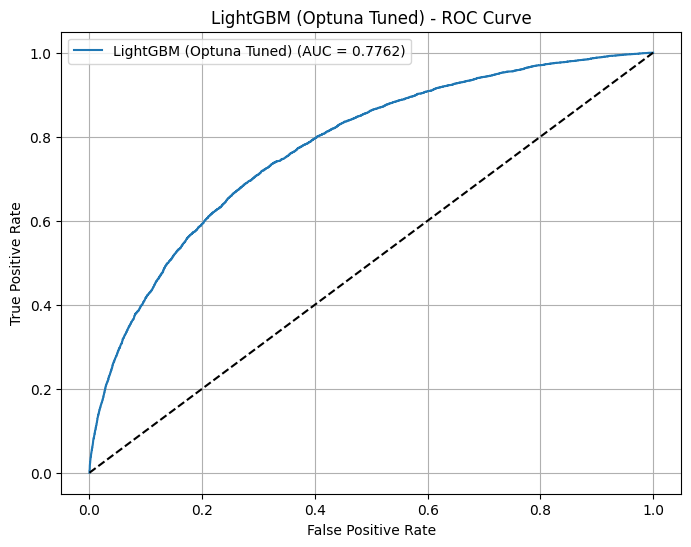


--- Top 50 Feature Importances ---
Sum of importances: 23491.0000


,feature,importance
6,CREDIT_ANNUITY_RATIO,1295
16,DAYS_BIRTH,570
20,CREDIT_GOODS_RATIO,553
106,AMT_ANNUITY,471
5,EXT_SOURCE_1,461
0,WEIGHTED_EXT_SOURCE,458
90,DAYS_ID_PUBLISH,452
1,EXT_SOURCE_MIN,446
39,DAYS_DETAILS_CHANGE_SUM,434
8,INCOME_EXT_RATIO,411


In [11]:
# --- Model 4: LightGBM with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 4: LightGBM with Optuna Optimization & GPU")
print("="*60)

# Step 4.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline LightGBM Training ---")
lgb_base_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=6, scale_pos_weight=11.5,
                                 device='gpu' if device_name == 'cuda' else 'cpu' # Enable GPU if available
                                ))
])

lgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = lgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LightGBM (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "LightGBM (Baseline)")
get_feature_importance(lgb_base_pipeline.named_steps['model'], feature_names)

# Step 4.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for LightGBM ---")

def objective_lgbm(trial):
    # Define hyperparameters
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': SEED,
        'n_jobs': 5,
        'device': 'gpu' if device_name == 'cuda' else 'cpu', # Enable GPU
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight' : 11.5,
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), # Optional: depends on dataset size
    }

    pipeline = ImblearnPipeline([
        #('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', lgb.LGBMClassifier(**param))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=5)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        # LightGBM can sometimes throw errors with certain parameter combos
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_lgbm = optuna.create_study(direction='maximize',
                                study_name='lgbm_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

# Create callbacks
early_stopping = EarlyStoppingCallback(patience=5, min_improvement=0.001)
timeout = TimeoutCallback(timeout=60)  # 1 hour timeout

# Run optimization with callbacks
print(f"Starting Optuna optimization for LightGBM with max {OPTUNA_N_TRIALS} trials (early stopping enabled)...")
start_time = time.time()
study_lgbm.optimize(objective_lgbm, n_trials=OPTUNA_N_TRIALS, callbacks=[early_stopping, timeout], n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_lgbm_raw = study_lgbm.best_params
best_params_lgbm = {f'model__{k}': v for k, v in best_params_lgbm_raw.items()}
print(f"\nBest Params (LightGBM): {best_params_lgbm_raw}")
print(f"Best CV ROC AUC score: {study_lgbm.best_value:.4f}")

best_lgb_pipeline = ImblearnPipeline([
    #('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=5,
                                 device='gpu' if device_name == 'cuda' else 'cpu'))
])
# Update only the tuned parameters
best_lgb_pipeline.set_params(**best_params_lgbm)

print("\nFitting best LightGBM pipeline on full training data...")
best_lgb_pipeline.fit(X_train, y_train)

# Step 4.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned LightGBM model...")
y_prob_oof_lgb = cross_val_predict(best_lgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_lgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lgb)

y_pred_proba_test_tuned = best_lgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LightGBM (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "LightGBM (Optuna Tuned)")
get_feature_importance(best_lgb_pipeline.named_steps['model'], feature_names)
model_objects['LGBM'] = best_lgb_pipeline # Store the best pipeline

# 7. Model 5: Stacking Classifier

In [13]:
# --- Model 5: Stacking Classifier ---
print("\n" + "="*60)
print("Model 6: Stacking Classifier")
print("="*60)

# Check if base models were successfully trained and stored
base_models_available = [name for name in ['LR_WOE', 'SGD', 'XGB', 'LGBM'] if name in model_objects]

if len(base_models_available) < 2:
    print("Need at least 2 successfully tuned base models to perform stacking. Skipping.")
    baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan}) # Add placeholder results
    tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
else:
    print(f"Using base models: {base_models_available}")

    # Define base estimators using the best pipelines/models found
    # Note: LR_WOE needs special handling as it uses pre-transformed data
    estimators = []
    # Need a way to handle the WOE input for the LR_WOE base model within StackingClassifier
    # This is complex. A common workaround is to retrain the non-WOE models without SMOTE/Scaling
    # within the stacking pipeline if the meta-learner benefits from raw probabilities.
    # OR, create custom transformers for WOE application within the stacking framework.
    # For simplicity here, let's use the pipelines *as is*, acknowledging potential inefficiencies.
    # We will exclude LR_WOE for now due to the input data difference.
    estimators = [(name, model_objects[name]) for name in base_models_available if name != 'LR_WOE']

    if not estimators:
         print("No suitable non-WOE base models found for stacking. Skipping.")
         baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan})
         tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
    else:
        # Define Meta Learner
        meta_learner = LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=5)

        # Create Stacking Classifier
        # Use 'predict_proba' for stack_method as meta-learner often benefits from probabilities
        # `passthrough=False` means only the predictions of base models are passed to meta-learner
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=meta_learner,
            cv=cv, # Use the same CV strategy for generating base model predictions
            stack_method='predict_proba',
            n_jobs=-1,
            passthrough=False # Usually False is better unless meta-learner needs original features too
        )

        # Train the Stacking Classifier
        print("Training Stacking Classifier...")
        start_stack_time = time.time()
        stacking_clf.fit(X_train, y_train)
        end_stack_time = time.time()
        print(f"Stacking Training Time: {(end_stack_time - start_stack_time)/60:.2f} minutes")


        # Optimal Threshold and Evaluation
        # Get OOF predictions (using internal CV of StackingClassifier isn't straightforward for threshold tuning)
        # Re-run cross_val_predict with the *fitted* stacking classifier is one way,
        # but might be computationally expensive as it retrains.
        # Alternative: Use the internal OOF predictions if accessible (not standard in sklearn's StackingClassifier)
        # Simplest approach for now: Use the fitted model and evaluate directly, find threshold on test preds (less ideal)
        # Or: find threshold on OOF predictions of the *meta-learner* if we could extract them.
        # Let's proceed with direct evaluation and acknowledge thresholding limitation here.

        print("Evaluating Stacking Classifier...")
        y_pred_proba_test_stack = stacking_clf.predict_proba(X_test)[:, 1]

        # Find threshold on test set probabilities (Sub-optimal, but simple for this structure)
        # Ideally, you'd get OOF predictions from the *stacking* process on the training set.
        # optimal_threshold_stack = find_optimal_threshold_j_statistic(y_test, y_pred_proba_test_stack) # Find on test for demo

        # For consistency, let's try getting OOF on train (might be slow)
        print("Getting OOF predictions for Stacking threshold tuning (may take time)...")
        y_prob_oof_stack = cross_val_predict(stacking_clf, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        optimal_threshold_stack = find_optimal_threshold_j_statistic(y_train, y_prob_oof_stack)

        y_pred_bin_test_stack = (y_pred_proba_test_stack >= optimal_threshold_stack).astype(int)

        # Store as both baseline and tuned result for Stacking
        stacking_eval_results = evaluate_model(y_test, y_pred_proba_test_stack, y_pred_bin_test_stack, "Stacking Classifier")
        baseline_results.append(stacking_eval_results)
        tuned_results.append(stacking_eval_results) # No separate tuning step shown here

        plot_roc_curve(y_test, y_pred_proba_test_stack, "Stacking Classifier")
        # Feature importance for stacking is typically done via SHAP on the meta-learner or permutation importance.
        # Or examine coefficients of the meta-learner:
        if hasattr(stacking_clf.final_estimator_, 'coef_'):
            print("\nMeta-Learner Coefficients (Importance of Base Models):")
            meta_coefs = pd.DataFrame({
                'Base Model': [name for name, _ in estimators],
                'Coefficient': np.abs(stacking_clf.final_estimator_.coef_[0]) # Abs value for importance magnitude
            }).sort_values('Coefficient', ascending=False)
            display(meta_coefs)
        model_objects['Stacking'] = stacking_clf # Store the model


Model 6: Stacking Classifier
Using base models: ['SGD', 'XGB', 'LGBM']
Training Stacking Classifier...


LightGBMError: Check failed: (best_split_info.right_count) > (0) at D:\a\1\s\lightgbm-python\src\treelearner\serial_tree_learner.cpp, line 862 .


# 8. Model Evaluation

In [ ]:
# --- Final Results Comparison ---
print("\n" + "="*60)
print("Overall Model Comparison")
print("="*60)

baseline_results_df = pd.DataFrame(baseline_results).set_index('Model')
tuned_results_df = pd.DataFrame(tuned_results).set_index('Model') # Now contains Optuna results

print("\n--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---")
display(baseline_results_df.sort_values('AUC', ascending=False))

print("\n--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---")
display(tuned_results_df.sort_values('AUC', ascending=False))

# --- Save Results ---
baseline_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "baseline_model_results.csv"))
tuned_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "tuned_model_results_optuna.csv")) # Updated filename
print(f"\nResults saved to {MODEL_OUTPUT_PATH}")

# Optionally save the best models
model_save_path = os.path.join(MODEL_OUTPUT_PATH, 'best_models_optuna.pkl')
try:
    with open(model_save_path, 'wb') as f:
        pickle.dump(model_objects, f)
    print(f"Best model objects saved to {model_save_path}")
except Exception as e:
    print(f"Could not save models: {e}")

# Optionally save the Optuna studies (they are also saved to the sqlite DB)
study_sgd.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_sgd_trials.csv'))
study_xgb.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_xgb_trials.csv'))
study_lgbm.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_lgbm_trials.csv'))

# Save the most important features from the best models
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.nan # Placeholder, will fill with actual importance later
})
for model_name, model in model_objects.items():
    if hasattr(model, 'feature_importances_'):
        feature_importance_df[model_name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importance_df[model_name] = np.abs(model.coef_[0]) # For linear models
    else:
        feature_importance_df[model_name] = np.nan

feature_importance_df = feature_importance_df.set_index('Feature').fillna(0) # Fill NaN with 0 for missing models
feature_importance_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, 'feature_importances.csv'))
print(f"\nFeature importances saved to {MODEL_OUTPUT_PATH}feature_importances.csv")

print("\nModeling complete.")


Overall Model Comparison

--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Baseline),0.77510,0.55021,0.41370,0.71398,0.17659,0.69426,0.28156,0.18447,0.54468
Stacking Classifier,0.77291,0.54582,0.40618,0.72144,0.17749,0.67432,0.28101,0.18979,0.57638
XGBoost (Baseline),0.75446,0.50893,0.37912,0.75380,0.18533,0.60363,0.28359,0.16483,0.49610
SGDClassifier (Baseline),0.72580,0.45159,0.33871,0.67682,0.15228,0.65760,0.24729,0.21175,0.63249



--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---


,AUC,Gini,KS,Accuracy,Precision,Recall,F1,Brier,LogLoss
Model,,,,,,,,,
LightGBM (Optuna Tuned),0.77845,0.55691,0.41835,0.70515,0.17482,0.71299,0.28080,0.06621,0.23923
XGBoost (Optuna Tuned),0.77773,0.55547,0.41597,0.67068,0.16361,0.74884,0.26854,0.06630,0.23952
Stacking Classifier,0.77291,0.54582,0.40618,0.72144,0.17749,0.67432,0.28101,0.18979,0.57638
SGDClassifier (Optuna Tuned),0.75644,0.51288,0.37752,0.67536,0.15846,0.70091,0.25849,0.20022,0.58677



Results saved to ./model_outputs/
Best model objects saved to ./model_outputs/best_models_optuna.pkl

Feature importances saved to ./model_outputs/feature_importances.csv

Modeling complete.
